# Clustering lynx

In [1]:
import random
import torch

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm
from gensim.models import Word2Vec
from sklearn.neighbors import NearestNeighbors
from oml.functional.metrics import calc_cmc, calc_map, calc_precision

/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# !pip install -U open-metric-learning --user --no-cache-dir
# !pip install gensim --user --no-cache-dir

## Load data

In [3]:
data = pd.read_csv("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_france.csv")
data

,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-04-27,NaN,1,0.938,854.8416,1054.8000,558.8352,289.0000
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-05-05,NaN,2,0.894,906.8544,948.9312,997.7472,1628.8128
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-17,NaN,3,0.939,1192.8384,821.8000,743.9040,465.8000
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-16,NaN,4,0.965,834.8832,673.8000,594.8640,518.8000
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-05,NaN,5,0.970,765.9080,315.9860,568.8540,392.9500
...,...,...,...,...,...,...,...,...,...,...,...,...
3108,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,2,0.925,668.7360,1152.9216,3805.5744,2295.8208
3109,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,3,0.949,1276.8192,880.9344,3906.6624,2475.8784
3110,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,4,0.902,615.8804,767.9859,1334.8447,828.8511
3111,/gpfsscratch/rech/ads/commun/datasets/extracte...,1017,OFB,SPOTS,2017-08-08,Chaux-Neuve,1,0.959,1797.7904,835.8592,470.8928,251.9680


### Selection of individuals

We are looking for individuals with around 10 images to test the evaluation metrics.

In [4]:
lynx_id_counts = data['lynx_id'].value_counts()
lynx_id_counts[50:70]

F25-069=J1-2019-1388    16
1342                    16
F25-030=B324            15
704                     15
1504                    14
2208                    14
1509                    14
F25-059=1196=1385       14
2446                    14
F39-091=1724            13
1350=B2011              13
1324                    13
F01-055=1363            13
F25-037                 13
1914                    12
2358                    12
2637                    12
Oslo                    12
2778                    12
F25-039                 11
Name: lynx_id, dtype: int64

In [5]:
selected_individuals = ["Oslo", "2778", "1914"]

In [6]:
data_selected_individuals = data[data["lynx_id"].isin(selected_individuals)]
data_selected_individuals = data_selected_individuals.copy()

### Generation of fake 2D image embeddings

In [7]:
def generate_embedding(lynx_id):
    if lynx_id == "Oslo":
        x = random.randint(0, 4)
        y = random.randint(0, 4)
    elif lynx_id == "1914":
        x = random.randint(6, 10)
        y = random.randint(6, 10)
    else:
        x = random.randint(0, 5)
        y = random.randint(5, 10)
        
    return [x, y]

In [8]:
data_selected_individuals["embedding"] = data_selected_individuals["lynx_id"].apply(generate_embedding)

In [9]:
data_selected_individuals[['embedding_x', 'embedding_y']] = pd.DataFrame(data_selected_individuals['embedding'].tolist(), index=data_selected_individuals.index)

In [10]:
data_selected_individuals.reset_index(drop=True, inplace=True)
data_selected_individuals['lynx_id_int'], _ = pd.factorize(data_selected_individuals["lynx_id"])

data_selected_individuals.head()

,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height,embedding,embedding_x,embedding_y,lynx_id_int
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2018-11-24,NaN,1,0.918,528.90,522.9640,295.95,168.9220,"[3, 2]",3,2,0
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2020-10-03,NaN,2,0.962,851.85,532.9170,255.90,171.9795,"[2, 4]",2,4,0
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2018-11-29,NaN,3,0.977,435.90,486.9813,378.00,244.9369,"[3, 1]",3,1,0
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2019-12-25,NaN,4,0.947,673.95,508.9643,277.95,147.9803,"[2, 4]",2,4,0
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2020-08-31,NaN,5,0.945,158.88,238.9500,181.92,99.9675,"[1, 3]",1,3,0


In [11]:
lynx_int_to_str = pd.Series(data_selected_individuals['lynx_id'].values, index=data_selected_individuals['lynx_id_int'].values).to_dict()
print(lynx_int_to_str)

lynx_str_to_int = {v: k for k, v in lynx_int_to_str.items()}
print(lynx_str_to_int)

{0: 'Oslo', 1: '1914', 2: '2778'}
{'Oslo': 0, '1914': 1, '2778': 2}


### Viewing individuals with their embeddings

Text(0.5, 1.0, 'Scatter plot des embeddings avec coloration par lynx_id')

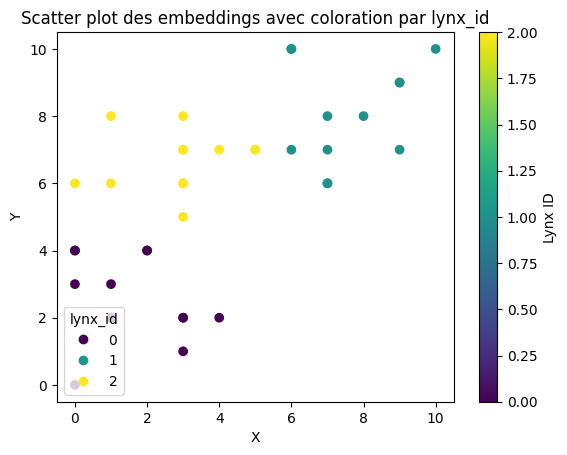

In [12]:
fig, ax = plt.subplots()

scatter = plt.scatter(data_selected_individuals['embedding_x'], data_selected_individuals['embedding_y'], c=data_selected_individuals['lynx_id_int'])

legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="lynx_id")

plt.colorbar(label="Lynx ID")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter plot des embeddings avec coloration par lynx_id")

## Reception of the image of a new candidate

The image is passed to the model and then we obtain an embedding (here 2D). Now, let's run a search using a candidate and a NearestNeighbors.

In [61]:
candidat_1 = [6, 6]

In [62]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric="minkowski").fit(data_selected_individuals["embedding"].values.tolist())

In [63]:
distances, indices = neighbors.kneighbors([candidat_1])
distances, indices[0]

(array([[1.        , 1.        , 1.        , 1.41421356, 1.41421356]]),
 array([20, 13, 12, 26, 19]))

In [64]:
individual_id = data_selected_individuals.loc[indices[0], "lynx_id"]
individual_id

20    1914
13    1914
12    1914
26    2778
19    1914
Name: lynx_id, dtype: object

In [65]:
individual_predicted_n_knn = individual_id.value_counts().idxmax()
individual_predicted_n_knn

'1914'

In [66]:
individual_predicted_1_knn = individual_id.iloc[0]
individual_predicted_1_knn_index = lynx_str_to_int[individual_predicted_1_knn]
print(individual_predicted_1_knn, individual_predicted_1_knn_index)

1914 1


#### Should we reject the individual prediction? Is it a new individual?

In [67]:
cluster_variances = {cluster_indices: np.var(data_selected_individuals[data_selected_individuals['lynx_id_int'] == cluster_indices]['embedding'].to_list(), axis=0) for cluster_indices in [0, 1, 2]}
cluster_variances

{0: array([1.90972222, 1.57638889]),
 1: array([1.74305556, 2.07638889]),
 2: array([2.13888889, 0.72222222])}

In [68]:
cluster_means = {cluster_indices: np.mean(data_selected_individuals[data_selected_individuals['lynx_id_int'] == cluster_indices]['embedding'].to_list(), axis=0) for cluster_indices in [0, 1, 2]}
cluster_means

{0: array([1.58333333, 2.58333333]),
 1: array([7.58333333, 8.08333333]),
 2: array([2.83333333, 6.66666667])}

In [69]:
confidence_level = 0.95

confidence_intervals = []
for mean, variance in zip(cluster_means.values(), cluster_variances.values()):
    interval = norm.interval(confidence_level, loc=mean, scale=np.sqrt(variance))
    confidence_intervals.append((np.array([interval[0][0], interval[1][0]]), np.array([interval[0][1], interval[1][1]])))
    
confidence_intervals

[(array([-1.12519381,  4.29186047]), array([0.12251375, 5.04415291])),
 (array([ 4.99569423, 10.17097244]), array([ 5.25908787, 10.90757879])),
 (array([-0.03310236,  5.69976903]), array([5.00101757, 8.33231577]))]

In [70]:
in_confidence_interval = all(
    interval[0] <= candidat_1[i] <= interval[1]
    for i, interval in enumerate(confidence_intervals[individual_predicted_1_knn_index])
)
in_confidence_interval

True

### Compute the metrics

Now let's calculate the metrics. To do this, we use the `open-metric-learning` module, which offers ready-made implementations of **CMC@k**, **mAP@k** and **Precision@k**. 

In [23]:
true_id = "1914"

In [24]:
def acc_k_list(nearest_individuals, true_individual):
    return nearest_individuals.apply(lambda x: x == true_individual).tolist()

In [25]:
gt_tops = torch.tensor([
                        acc_k_list(individual_id, true_id)
], dtype=torch.bool)

n_gt = torch.tensor([5])

top_k=(1,2,3,4,5)

print(gt_tops)
print(n_gt)

tensor([[False, False, False, False, False]])
tensor([5])


#### CMC@k (Cumulative Matching Characteristics) 

In [26]:
calc_cmc(gt_tops, top_k)

[tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.])]

#### mAP@k (mean Average Precision)

In [27]:
calc_map(gt_tops=gt_tops, n_gt=n_gt, top_k=top_k)

[tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.])]

#### Precision@k

In [28]:
calc_precision(gt_tops=gt_tops, n_gt=n_gt, top_k=top_k)

[tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.])]